In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


File              ML algorithm       accuracy        Precision       Recall          F1-score        Time           
all_data          Naive Bayes        0.36            0.63            0.56            0.34            5.9272         


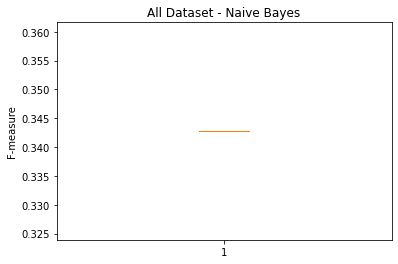

all_data          QDA                0.48            0.66            0.64            0.48            7.8704         


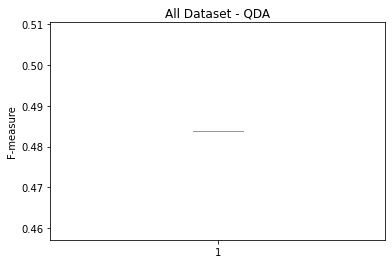

all_data          Random Forest      0.93            0.93            0.89            0.9             46.8734        


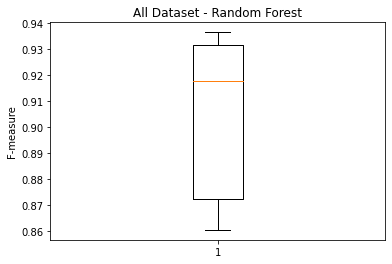

all_data          ID3                0.94            0.94            0.91            0.92            26.7957        


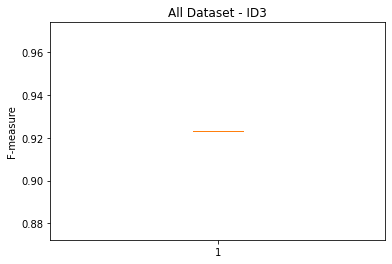

all_data          AdaBoost           0.94            0.94            0.91            0.92            366.9898       


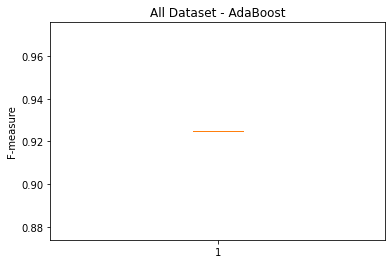

all_data          MLP                0.83            0.86            0.69            0.7             1644.2069      


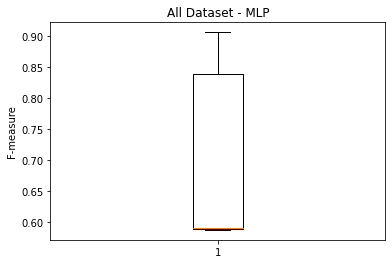

all_data          Nearest Neighbors  0.96            0.95            0.94            0.94            1222.3205      


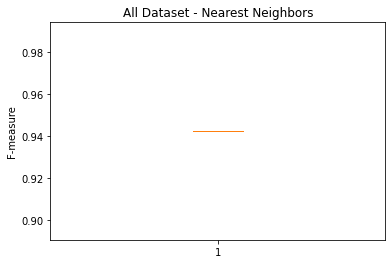

Mission accomplished!
Total operation time: =  33260.33935523033 seconds


In [ ]:
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import csv
import time
import warnings
import math

%matplotlib inline
warnings.filterwarnings("ignore")

# The name and path of the results
result = "/content/drive/MyDrive/ISU/results/results_3.csv"
csv_files = ["all_data.csv"]
path = "/content/drive/MyDrive/ISU/"
repetition = 10

# Create "results" and "result_graph_3" folder
def folder(f_name):
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print("The folder could not be created!")

# Path:
folder_name = "/content/drive/MyDrive/ISU/results/"
folder(folder_name)
folder_name = "/content/drive/MyDrive/ISU/results/result_graph_3/"
folder(folder_name)

# List of machine learning algorithms:
ml_list = {
    "Naive Bayes": GaussianNB(),
    "QDA": QDA(),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "ID3": DecisionTreeClassifier(max_depth=5, criterion="entropy"),
    "AdaBoost": AdaBoostClassifier(),
    "MLP": MLPClassifier(hidden_layer_sizes=(13, 13, 13, 13, 13), max_iter=500),
    "Nearest Neighbors": KNeighborsClassifier(3)}

# The 7 features with the highest importance weight selected by the file "1.4.b_SelectFeature_alldata.py" are used here
features = {
    "all_data": ["Flow IAT Min", "Bwd Pkt Len Mean", "Fwd Pkt Len Std", "Fwd IAT Tot", "Bwd Pkt Len Std", "Flow Byts/s",
                 "Fwd IAT Max", "Label"]}

# Timestamp
seconds = time.time()

# Create a CSV file to save the results
with open(result, "w", newline="", encoding="utf-8") as f:
    wrt = csv.writer(f)
    wrt.writerow(["File", "ML algorithm", "accuracy", "Precision", "Recall", "F1-score", "Time"])

# This loop runs on the list containing the filenames. Operations are repeated for all attack files
for j in csv_files:
    print('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (
        "File", "ML algorithm", "accuracy", "Precision", "Recall", "F1-score", "Time"))
    feature_list = list(features[j[0:-4]])
    # Read ""all_data"" file
    df = pd.read_csv(path + j, usecols=feature_list)
    # Replace NaN with 0
    df.fillna(0, inplace=True)
    # Replace Infinity with -1
    df.replace([np.inf, -np.inf], -1, inplace=True)
    attack_or_not = []

    # Change "Label" to 0/1 beased on the data is "Benign" or attack
    for i in df["Label"]:
        if i == "Benign":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)

    df["Label"] = attack_or_not
    # Separate label and data into 2 pieces, data=x Label=y
    y = df["Label"]
    del df["Label"]
    feature_list.remove('Label')
    X = df[feature_list]

    # This loop runs on the list containing the machine learning algorithm names. Operations are repeated for all the 7 algorithm
    for ii in ml_list:
        precision = []
        recall = []
        f1 = []
        accuracy = []
        t_time = []

        # This loop allows cross-validation and machine learning algorithm to be repeated 10 times
        for i in range(repetition):
            second = time.time()
            # Cross-validation
            # Data(X) and Labels(y) are divided into 2 parts to be sent to the machine learning algorithm (80% train, %20 test)
            # In total there are 4 tracks: training data(X_train), training tag(y_train), test data(X_test) and test tag(y_test)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=repetition)
            # Machine learning algorithms are applied in this section
            # Choose algorithm from ml_list dictionary
            clf = ml_list[ii]
            clf.fit(X_train, y_train)
            predict = clf.predict(X_test)
            # Make "classification report" and assign the precision, f-measure, and recall values
            f_1 = f1_score(y_test, predict, average='macro')
            pr = precision_score(y_test, predict, average='macro')
            rc = recall_score(y_test, predict, average='macro')
            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time() - second)))

        # Print the result of ten repetitions
        print('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (
            j[0:-4], ii, str(round(np.mean(accuracy), 2)), str(round(np.mean(precision), 2)),
            str(round(np.mean(recall), 2)), str(round(np.mean(f1), 2)), str(round(np.mean(t_time), 4))))

        # Save all the values in the file
        with open(result, "a", newline="", encoding="utf-8") as f:
            wrt = csv.writer(f)

            for i in range(0, len(t_time)):
                # Write file name, algorithm name, precision, recall and f-measure in CSV file
                wrt.writerow([j[0:-4], ii, accuracy[i], precision[i], recall[i], f1[i], t_time[i]])

        # Create and save the graphics results
        plt.boxplot(f1)
        plt.title("All Dataset - " + str(ii))
        plt.ylabel('F-measure')
        plt.savefig(folder_name + j[0:-4] + str(ii) + ".pdf", bbox_inches='tight', papertype='a4',
                    orientation='portrait', format='pdf')
        plt.show()

print("Mission accomplished!")
print("Total operation time: = ", time.time() - seconds, "seconds")
